<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [12]</a>'.</span>

In [1]:
# | code-summary: code -- load dependencies and data and select parameters

from compmemlearn.fitting import generate_objective_function
from compmemlearn.datasets import events_metadata, simulate_df, generate_trial_mask
from scipy.optimize import differential_evolution
from numba.typed import List, Dict
from numba.core import types
from numba import njit
from psifr import fr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import os

lb = np.finfo(float).eps
ub = 1 - np.finfo(float).eps

figure_caption = """Distribution of log-likelihood scores of recall sequences exhibited by each subject in dataset under each considered model."""

section_tag = "LohnasCondition1"

data_path = "../data/LohnasKahana2014.csv"
results_path = "results/"
trial_query = "condition == 1"

model_paths = ["compmemlearn.models.Classic_CMR", "compmemlearn.models.Instance_CMR", "compmemlearn.models.Dual_Instance_CMR"]

model_names = ["PrototypeCMR", "InstanceCMR", "Dual Memory ICMR"]

free_parameters = [
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        #    'choice_sensitivity',
        "context_sensitivity",
        #    'feature_sensitivity'
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        #    'choice_sensitivity',
        "context_sensitivity",
        #    'feature_sensitivity'
        "delay_drift_rate",
    ],
]

bounds = [
    [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
    [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
    [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
]

fixed_parameters = [
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    {"choice_sensitivity": 1, "feature_sensitivity": 1, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0},
    {"choice_sensitivity": 1, "feature_sensitivity": 1, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0},
]

analysis_paths = ['compmemlearn.analyses.plot_spc', 'compmemlearn.analyses.plot_crp', 'compmemlearn.analyses.plot_pfr']
analysis_names = ['spc', 'crp', 'pfr']

experiment_count = 100


In [2]:
# Parameters
data_path = "data/HealyKahana2014.csv"
trial_query = "task == -1"
model_paths = [
    "compmemlearn.models.Base_CMR",
    "compmemlearn.models.Single_ICMR",
    "compmemlearn.models.Single_ICMR",
    "compmemlearn.models.Single_ICMR",
    "compmemlearn.models.Single_ICMR",
]
model_names = ["PrototypeCMR", "ICMR_1_0_0", "ICMR_1_0_1", "ICMR_1_1_0", "ICMR_1_1_1"]
free_parameters = [
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "context_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "context_sensitivity",
        "delay_drift_rate",
    ],
]
bounds = [
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
]
fixed_parameters = [
    {},
    {"feature_sensitivity": 1, "context_sensitivity": 1, "learn_first": False},
    {"feature_sensitivity": 1, "context_sensitivity": 1, "learn_first": True},
    {"feature_sensitivity": 1, "choice_sensitivity": 1, "learn_first": False},
    {"feature_sensitivity": 1, "choice_sensitivity": 1, "learn_first": True},
]
section_tag = "HealyKahana2014"


In [3]:
#| code-summary: code -- test that specified parameters are valid
#| output: false

events = pd.read_csv(data_path)

trials, list_lengths, presentations = events_metadata(events)
trial_mask = generate_trial_mask(events, trial_query)

# import models from specified source
models = []
for i in range(len(model_paths)):
    module_name, model_name = model_paths[i].rsplit('.',1) #TODO: add handling for case with no `.`
    module = importlib.import_module(module_name)
    models.append(getattr(module, model_name))

# import analyses from specified source
analyses = []
for i in range(len(analysis_paths)):
    module_name, analysis_name = analysis_paths[i].rsplit('.',1) #TODO: add handling for case with no `.`
    module = importlib.import_module(module_name)
    analyses.append(getattr(module, analysis_name))

# make sure model initializes with provided parameters and boundaries
for model_index, model_class in enumerate(models):

    @njit(fastmath=True, nogil=True)
    def init_model(item_count, presentation_count, parameters):
        return model_class(item_count, presentation_count, parameters)

    subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f'subject == {pd.unique(events.subject)[0]}'), trial_mask)

    cost_function = generate_objective_function(
        [trials[i][subject_specific_trial_mask[i]] for i in range(len(trials))],
        [presentations[i][subject_specific_trial_mask[i]] for i in range(len(presentations))],
        list_lengths,
        init_model,
        fixed_parameters[model_index],
        free_parameters[model_index],
    )
    print(cost_function)
    
    for boundary_index in range(2):
        x = np.array([each[boundary_index] for each in bounds[model_index]])
        assert(len(x) == len(free_parameters[model_index])) 

        # parameter configuration
        parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
        for name, value in fixed_parameters[model_index].items():
            parameters[name] = value
        for i in range(len(free_parameters[model_index])):
                parameters[free_parameters[model_index][i]] = x[i]

        model = init_model(20, 20, parameters)
        model.experience(model.items)
        model.free_recall()

        print(cost_function(x))
print('dependencies and parameters validated')
#print(trial_index, recall_index, recall, trial, likelihood[trial_index, recall_index], model.outcome_probabilities())

<function murdock_objective_function.<locals>.objective_function at 0x2ab364cf24c0>


1698.9503048991148
4144.6533153898135


<function murdock_objective_function.<locals>.objective_function at 0x2ab36573a0d0>


1698.9503048991148
4144.6533153898135
<function murdock_objective_function.<locals>.objective_function at 0x2ab3668bb310>


1698.9503048991148
4144.6533153898135
<function murdock_objective_function.<locals>.objective_function at 0x2ab3659a6c10>


1698.9503048991148
4144.6533153898135
<function murdock_objective_function.<locals>.objective_function at 0x2ab3668bba60>


1698.9503048991148
4144.6533153898135
dependencies and parameters validated


In [4]:
# | code-summary: code -- 1) fit each model class participant-by-participant
# | output: false

for model_index, model_class in enumerate(models):

    # load individual fits for this model and section tag from csv if they exist
    if os.path.isfile(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index])):
        pd.read_csv(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index]))
        print('individual fits for {} with tag {} already exist'.format(model_names[model_index], section_tag))

    # otherwise, fit each participant individually
    else:
        model_individual_fits = []

        @njit(fastmath=True, nogil=True)
        def init_model(item_count, presentation_count, parameters):
            return model_class(item_count, presentation_count, parameters)

        for subject in pd.unique(events.subject):
            print(f'{model_names[model_index]}, Subject {subject}')

            subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f'subject == {subject}'), trial_mask)
            
            try:
                # cost function to be minimized
                # ours scales inversely with the probability that the data could have been
                # generated using the specified parameters and our model
                cost_function = generate_objective_function(
                    [trials[i][subject_specific_trial_mask[i]] for i in range(len(trials))],
                    [presentations[i][subject_specific_trial_mask[i]] for i in range(len(presentations))],
                    list_lengths,
                    init_model,
                    fixed_parameters[model_index],
                    free_parameters[model_index],
                )
            except ValueError:
                continue

            fit_result =  differential_evolution(cost_function, bounds[model_index], disp=False)

            fitted_parameters = {
                'subject': subject, 'trial_count': np.sum(subject_specific_trial_mask), 
                'likelihood': fit_result.fun, 'model': model_names[model_index]
                }
            for i in range(len(fit_result.x)):
                fitted_parameters[free_parameters[model_index][i]] = fit_result.x[i]
            for key in fixed_parameters[model_index]:
                fitted_parameters[key] = fixed_parameters[model_index][key]

            model_individual_fits.append(pd.DataFrame.from_dict(fitted_parameters, orient='index').T)
            print(model_individual_fits[-1]['likelihood'][0])

        model_individual_fits = pd.concat(model_individual_fits, ignore_index=True)
        model_individual_fits.to_csv(
            results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index]), index=False)

individual fits for PrototypeCMR with tag HealyKahana2014 already exist
ICMR_1_0_0, Subject 63


729.7684389293258
ICMR_1_0_0, Subject 64


515.0197444158819
ICMR_1_0_0, Subject 65


501.3074166831034
ICMR_1_0_0, Subject 66


618.3521731355106
ICMR_1_0_0, Subject 67


728.6671638538376
ICMR_1_0_0, Subject 69


638.1306578305057
ICMR_1_0_0, Subject 70


506.09000705168967
ICMR_1_0_0, Subject 73


656.0362581887357
ICMR_1_0_0, Subject 74


605.6626355790362
ICMR_1_0_0, Subject 75


433.35640267759425
ICMR_1_0_0, Subject 76


648.385866898301
ICMR_1_0_0, Subject 77


640.4101750557274
ICMR_1_0_0, Subject 79


544.5642264187389
ICMR_1_0_0, Subject 81


678.952594481726
ICMR_1_0_0, Subject 82


626.434209470211
ICMR_1_0_0, Subject 84


523.67095690203
ICMR_1_0_0, Subject 85


456.02164766687156
ICMR_1_0_0, Subject 86


643.7906888412837
ICMR_1_0_0, Subject 87


512.2824733777617
ICMR_1_0_0, Subject 88


674.2971558611697
ICMR_1_0_0, Subject 89


605.407555224942
ICMR_1_0_0, Subject 90


643.1038420929373
ICMR_1_0_0, Subject 91


552.1041572959513
ICMR_1_0_0, Subject 92


790.5267193925949
ICMR_1_0_0, Subject 93


445.61536346395997
ICMR_1_0_0, Subject 94


471.2604683202488
ICMR_1_0_0, Subject 95


575.1698590958019
ICMR_1_0_0, Subject 96


410.6016952919046
ICMR_1_0_0, Subject 98


748.7392703418271
ICMR_1_0_0, Subject 99


680.1993717257263
ICMR_1_0_0, Subject 100


543.5015639224613
ICMR_1_0_0, Subject 101


712.1988037524774
ICMR_1_0_0, Subject 102


601.293631599708
ICMR_1_0_0, Subject 103


396.1363174480371
ICMR_1_0_0, Subject 104


656.6874685362609
ICMR_1_0_0, Subject 105


595.5999147157426
ICMR_1_0_0, Subject 106


746.9495361737825
ICMR_1_0_0, Subject 107


591.4946734318436
ICMR_1_0_0, Subject 108


636.8509434144779
ICMR_1_0_0, Subject 110


724.4026283175865
ICMR_1_0_0, Subject 111


724.447709913902
ICMR_1_0_0, Subject 112


618.5989392578538
ICMR_1_0_0, Subject 113


528.9347865025451
ICMR_1_0_0, Subject 114


587.190815814094
ICMR_1_0_0, Subject 115


614.7929086172456
ICMR_1_0_0, Subject 117


622.7968414937427
ICMR_1_0_0, Subject 118


395.47458101770496
ICMR_1_0_0, Subject 119


655.5424787592199
ICMR_1_0_0, Subject 120


484.37281710352323
ICMR_1_0_0, Subject 122


682.1653560929362
ICMR_1_0_0, Subject 123


526.536874757802
ICMR_1_0_0, Subject 124


674.6383254235104
ICMR_1_0_0, Subject 125


592.5821497982239
ICMR_1_0_0, Subject 127


647.5390029827739
ICMR_1_0_0, Subject 128


706.7843637795363
ICMR_1_0_0, Subject 130


458.19860985638167
ICMR_1_0_0, Subject 131


705.7726048259026
ICMR_1_0_0, Subject 132


579.3357077367044
ICMR_1_0_0, Subject 133


561.974602696468
ICMR_1_0_0, Subject 134


612.3420925422988
ICMR_1_0_0, Subject 135


511.6316395898468
ICMR_1_0_0, Subject 136


521.1477280406218
ICMR_1_0_0, Subject 137


735.5474762186458
ICMR_1_0_0, Subject 138


725.117555010314
ICMR_1_0_0, Subject 139


746.1196939768098
ICMR_1_0_0, Subject 140


602.0591065966713
ICMR_1_0_0, Subject 141


550.0802117996349
ICMR_1_0_0, Subject 142


669.67753111363
ICMR_1_0_0, Subject 143


540.9965548419283
ICMR_1_0_0, Subject 144


570.0972201006329
ICMR_1_0_0, Subject 145


725.1021260309057
ICMR_1_0_0, Subject 146


550.6085466499492
ICMR_1_0_0, Subject 147


661.6043703793703
ICMR_1_0_0, Subject 148


582.5609772830393
ICMR_1_0_0, Subject 149


701.2648515331416
ICMR_1_0_0, Subject 150


437.81909792437085
ICMR_1_0_0, Subject 151


507.3951671949405
ICMR_1_0_0, Subject 153


687.096969103814
ICMR_1_0_0, Subject 155


565.2533912742895
ICMR_1_0_0, Subject 159


452.35956988867343
ICMR_1_0_0, Subject 166


582.9937101054705
ICMR_1_0_0, Subject 168


505.15807933012917
ICMR_1_0_0, Subject 174


549.0618635603608
ICMR_1_0_0, Subject 184


633.5264459903127
ICMR_1_0_0, Subject 185


539.5184678591785
ICMR_1_0_0, Subject 186


722.2155411149747
ICMR_1_0_0, Subject 187


453.1032868489959
ICMR_1_0_0, Subject 188


326.86632712536635
ICMR_1_0_0, Subject 189


538.4637978231215
ICMR_1_0_0, Subject 190


349.98750514939854
ICMR_1_0_0, Subject 191


707.2006515934914
ICMR_1_0_0, Subject 192


604.1589674569947
ICMR_1_0_0, Subject 193


797.3456835359106
ICMR_1_0_0, Subject 194


540.5155530972065
ICMR_1_0_0, Subject 195


786.7066363501348
ICMR_1_0_0, Subject 196


611.8412107386852
ICMR_1_0_0, Subject 197


699.2280673148274
ICMR_1_0_0, Subject 198


786.8648105145934
ICMR_1_0_0, Subject 199


565.4322232539589
ICMR_1_0_0, Subject 200


603.7014491348397
ICMR_1_0_0, Subject 201


571.1696691704653
ICMR_1_0_0, Subject 202


631.0246193928873
ICMR_1_0_0, Subject 207


579.9484720365335
ICMR_1_0_0, Subject 209


633.2525938446979
ICMR_1_0_0, Subject 210


567.9364401207155
ICMR_1_0_0, Subject 211


388.07494948393816
ICMR_1_0_0, Subject 212


530.4149137130288
ICMR_1_0_0, Subject 215


514.1185499473034
ICMR_1_0_0, Subject 227


522.9406016913517
ICMR_1_0_0, Subject 228


498.9912343012506
ICMR_1_0_0, Subject 229


653.9913699233831
ICMR_1_0_0, Subject 230


523.7264448912732
ICMR_1_0_0, Subject 231


601.7255984374704
ICMR_1_0_0, Subject 232


808.8079681203919
ICMR_1_0_0, Subject 233


635.6042152331792
ICMR_1_0_0, Subject 234


479.7507985580565
ICMR_1_0_0, Subject 235


609.4848734749595
ICMR_1_0_0, Subject 236


618.063695048584
ICMR_1_0_0, Subject 237


465.17170036309386
ICMR_1_0_0, Subject 238


473.67932713508367
ICMR_1_0_0, Subject 239


538.8365314527733
ICMR_1_0_0, Subject 240


513.2461464959665
ICMR_1_0_0, Subject 241


643.4143218290149
ICMR_1_0_0, Subject 242


511.9241282407704
ICMR_1_0_0, Subject 243


616.6483628192261
ICMR_1_0_0, Subject 244


653.8539898912285


ICMR_1_0_1, Subject 63


708.3499064667527
ICMR_1_0_1, Subject 64


511.0570431123327
ICMR_1_0_1, Subject 65


500.93720822987
ICMR_1_0_1, Subject 66


618.5901042192376
ICMR_1_0_1, Subject 67


628.9722158425534
ICMR_1_0_1, Subject 69


638.2623089180144
ICMR_1_0_1, Subject 70


505.6296426020756
ICMR_1_0_1, Subject 73


653.8877766586554
ICMR_1_0_1, Subject 74


615.1479878008868
ICMR_1_0_1, Subject 75


433.34715457605205
ICMR_1_0_1, Subject 76


646.5965647106968
ICMR_1_0_1, Subject 77


640.2618222523552
ICMR_1_0_1, Subject 79


537.9121181111678
ICMR_1_0_1, Subject 81


680.4547062365481
ICMR_1_0_1, Subject 82


626.288203582161
ICMR_1_0_1, Subject 84


531.796716344458
ICMR_1_0_1, Subject 85


456.0950119235849
ICMR_1_0_1, Subject 86


643.593862373325
ICMR_1_0_1, Subject 87


512.2827930002105
ICMR_1_0_1, Subject 88


674.2971226448402
ICMR_1_0_1, Subject 89


605.2801108451775
ICMR_1_0_1, Subject 90


636.8561028555961
ICMR_1_0_1, Subject 91


560.6483669397692
ICMR_1_0_1, Subject 92


791.996472153234
ICMR_1_0_1, Subject 93


444.9723692833965
ICMR_1_0_1, Subject 94


471.26046933076765
ICMR_1_0_1, Subject 95


565.1791597912526
ICMR_1_0_1, Subject 96


411.50153726326363
ICMR_1_0_1, Subject 98


686.6580244741266
ICMR_1_0_1, Subject 99


680.1160922299832
ICMR_1_0_1, Subject 100


543.4313199020851
ICMR_1_0_1, Subject 101


711.435056574183
ICMR_1_0_1, Subject 102


601.2936385793282
ICMR_1_0_1, Subject 103


375.1643830736545
ICMR_1_0_1, Subject 104


665.7404214380862
ICMR_1_0_1, Subject 105


590.4205448836351
ICMR_1_0_1, Subject 106


748.4504071913424
ICMR_1_0_1, Subject 107


591.5100059067377
ICMR_1_0_1, Subject 108


636.8508967341986
ICMR_1_0_1, Subject 110


714.6372839678107
ICMR_1_0_1, Subject 111


704.8584341475593
ICMR_1_0_1, Subject 112


618.3930355433653
ICMR_1_0_1, Subject 113


528.9347907535138
ICMR_1_0_1, Subject 114


575.3983764094722
ICMR_1_0_1, Subject 115


614.793794820012
ICMR_1_0_1, Subject 117


623.6764657753592
ICMR_1_0_1, Subject 118


395.39046842930026
ICMR_1_0_1, Subject 119


655.5454234211994
ICMR_1_0_1, Subject 120


483.4755670177884
ICMR_1_0_1, Subject 122


691.1159141191756
ICMR_1_0_1, Subject 123


526.3501309145628
ICMR_1_0_1, Subject 124


674.4990686906127
ICMR_1_0_1, Subject 125


591.3972908316655
ICMR_1_0_1, Subject 127


654.8260347150339
ICMR_1_0_1, Subject 128


707.5361182984074
ICMR_1_0_1, Subject 130


458.51473429642255
ICMR_1_0_1, Subject 131


706.823377344317
ICMR_1_0_1, Subject 132


587.4375126015408
ICMR_1_0_1, Subject 133


561.9751063297063
ICMR_1_0_1, Subject 134


609.9430126193894
ICMR_1_0_1, Subject 135


512.6297429665733
ICMR_1_0_1, Subject 136


543.3276232613042
ICMR_1_0_1, Subject 137


742.7649577374312
ICMR_1_0_1, Subject 138


723.6984536309734
ICMR_1_0_1, Subject 139


761.0626632174259
ICMR_1_0_1, Subject 140


602.5822786402489
ICMR_1_0_1, Subject 141


654.5412281104122
ICMR_1_0_1, Subject 142


669.6941447852297
ICMR_1_0_1, Subject 143


541.012394132106
ICMR_1_0_1, Subject 144


566.020710176361
ICMR_1_0_1, Subject 145


717.6812900582006
ICMR_1_0_1, Subject 146


543.4356092197143
ICMR_1_0_1, Subject 147


660.5244620240654
ICMR_1_0_1, Subject 148


582.5617990079721
ICMR_1_0_1, Subject 149


710.3387050769215
ICMR_1_0_1, Subject 150


435.8040964223169
ICMR_1_0_1, Subject 151


507.20326780255454
ICMR_1_0_1, Subject 153


686.9146074350612
ICMR_1_0_1, Subject 155


620.2203436790226
ICMR_1_0_1, Subject 159


452.3649511983351
ICMR_1_0_1, Subject 166


582.8179593893551
ICMR_1_0_1, Subject 168


504.60446053474135
ICMR_1_0_1, Subject 174


551.5036088140039
ICMR_1_0_1, Subject 184


641.4692926109421
ICMR_1_0_1, Subject 185


541.1636605864339
ICMR_1_0_1, Subject 186


626.7843238724106
ICMR_1_0_1, Subject 187


451.232619849176
ICMR_1_0_1, Subject 188


319.7775835350292
ICMR_1_0_1, Subject 189


538.4604399603418
ICMR_1_0_1, Subject 190


350.5624086158406
ICMR_1_0_1, Subject 191


692.6822670078144
ICMR_1_0_1, Subject 192


604.1586231086922
ICMR_1_0_1, Subject 193


808.9384078374673
ICMR_1_0_1, Subject 194


570.6073112601727
ICMR_1_0_1, Subject 195


785.7072593477366
ICMR_1_0_1, Subject 196


607.9824484305034
ICMR_1_0_1, Subject 197


692.2841763734272
ICMR_1_0_1, Subject 198


834.9003509169518
ICMR_1_0_1, Subject 199


564.6703614524647
ICMR_1_0_1, Subject 200


615.8875685217082
ICMR_1_0_1, Subject 201


571.223029953236
ICMR_1_0_1, Subject 202


623.4225938979002
ICMR_1_0_1, Subject 207


585.4157297137496
ICMR_1_0_1, Subject 209


633.2533782681644
ICMR_1_0_1, Subject 210


567.9409036717735
ICMR_1_0_1, Subject 211


388.06210795163116
ICMR_1_0_1, Subject 212


526.8660255843945
ICMR_1_0_1, Subject 215


513.7834000566852
ICMR_1_0_1, Subject 227


522.8697359364472
ICMR_1_0_1, Subject 228


500.21387451330776
ICMR_1_0_1, Subject 229


656.9917042514438
ICMR_1_0_1, Subject 230


509.2417951176139
ICMR_1_0_1, Subject 231


709.0184991068436
ICMR_1_0_1, Subject 232


671.8675399842208
ICMR_1_0_1, Subject 233


633.9936824914478
ICMR_1_0_1, Subject 234


479.49534333945627
ICMR_1_0_1, Subject 235


609.6556479856678
ICMR_1_0_1, Subject 236


620.1410759465826
ICMR_1_0_1, Subject 237


466.29682707442123
ICMR_1_0_1, Subject 238


473.67917344964224
ICMR_1_0_1, Subject 239


537.4631478663907
ICMR_1_0_1, Subject 240


512.8006782954604
ICMR_1_0_1, Subject 241


724.1491124430052
ICMR_1_0_1, Subject 242


519.915201003807
ICMR_1_0_1, Subject 243


609.6556823183556
ICMR_1_0_1, Subject 244


667.5818120571738
ICMR_1_1_0, Subject 63


693.2612191818142
ICMR_1_1_0, Subject 64


512.5662355209589
ICMR_1_1_0, Subject 65


503.2563009783086
ICMR_1_1_0, Subject 66


797.9934205415917
ICMR_1_1_0, Subject 67


628.7007593837503
ICMR_1_1_0, Subject 69


638.4426981948995
ICMR_1_1_0, Subject 70


505.99018745621873
ICMR_1_1_0, Subject 73


657.8058321913827
ICMR_1_1_0, Subject 74


609.7818706686687
ICMR_1_1_0, Subject 75


434.228478642097
ICMR_1_1_0, Subject 76


646.0250345581868
ICMR_1_1_0, Subject 77


643.7316079861293
ICMR_1_1_0, Subject 79


538.8242574491957
ICMR_1_1_0, Subject 81


681.2813744460472
ICMR_1_1_0, Subject 82


627.2763270972686
ICMR_1_1_0, Subject 84


523.2548656897424
ICMR_1_1_0, Subject 85


461.30640070560196
ICMR_1_1_0, Subject 86


644.1192426947559
ICMR_1_1_0, Subject 87


512.890829324884
ICMR_1_1_0, Subject 88


674.7309679797391
ICMR_1_1_0, Subject 89


603.9898985941362
ICMR_1_1_0, Subject 90


643.3850670438474
ICMR_1_1_0, Subject 91


545.578799600303
ICMR_1_1_0, Subject 92


815.5672760371865
ICMR_1_1_0, Subject 93


443.5172744600475
ICMR_1_1_0, Subject 94


471.86861500683386
ICMR_1_1_0, Subject 95


565.1428716833228
ICMR_1_1_0, Subject 96


411.35316643277935
ICMR_1_1_0, Subject 98


690.0528040938755
ICMR_1_1_0, Subject 99


681.0497062344666
ICMR_1_1_0, Subject 100


545.7740690607798
ICMR_1_1_0, Subject 101


714.5193209155743
ICMR_1_1_0, Subject 102


601.4899544438605
ICMR_1_1_0, Subject 103


374.66553865248665
ICMR_1_1_0, Subject 104


654.8107420781618
ICMR_1_1_0, Subject 105


594.5382355374458
ICMR_1_1_0, Subject 106


751.165129158604
ICMR_1_1_0, Subject 107


585.6184088823528
ICMR_1_1_0, Subject 108


637.771878205808
ICMR_1_1_0, Subject 110


724.6541369269357
ICMR_1_1_0, Subject 111


706.4804744121445
ICMR_1_1_0, Subject 112


618.4457343779259
ICMR_1_1_0, Subject 113


527.2308178757653
ICMR_1_1_0, Subject 114


575.2291293702849
ICMR_1_1_0, Subject 115


615.9452752865584
ICMR_1_1_0, Subject 117


623.1463427732978
ICMR_1_1_0, Subject 118


395.3840928445517
ICMR_1_1_0, Subject 119


744.5941100787282
ICMR_1_1_0, Subject 120


483.29455794399496
ICMR_1_1_0, Subject 122


681.9773348888456
ICMR_1_1_0, Subject 123


527.5548699192689
ICMR_1_1_0, Subject 124


716.0302504709827
ICMR_1_1_0, Subject 125


591.9597656222046
ICMR_1_1_0, Subject 127


648.2997183166989
ICMR_1_1_0, Subject 128


708.2560095699166
ICMR_1_1_0, Subject 130


463.06388587200536
ICMR_1_1_0, Subject 131


695.8207056324183
ICMR_1_1_0, Subject 132


580.4924918700061
ICMR_1_1_0, Subject 133


562.1133284301648
ICMR_1_1_0, Subject 134


608.8549621159452
ICMR_1_1_0, Subject 135


511.63781865834665
ICMR_1_1_0, Subject 136


553.959590998442
ICMR_1_1_0, Subject 137


735.4554938766412
ICMR_1_1_0, Subject 138


717.3505005612625
ICMR_1_1_0, Subject 139


748.4995894873662
ICMR_1_1_0, Subject 140


601.8485279006713
ICMR_1_1_0, Subject 141


552.3290410375478
ICMR_1_1_0, Subject 142


669.7088741453168
ICMR_1_1_0, Subject 143


536.3374284270459
ICMR_1_1_0, Subject 144


569.0727548313848
ICMR_1_1_0, Subject 145


800.8601679932599
ICMR_1_1_0, Subject 146


550.9960897914063
ICMR_1_1_0, Subject 147


662.0059700215661
ICMR_1_1_0, Subject 148


583.6157485817336
ICMR_1_1_0, Subject 149


709.9439045724025
ICMR_1_1_0, Subject 150


435.60327454499355
ICMR_1_1_0, Subject 151


506.4916598319513
ICMR_1_1_0, Subject 153


687.141809582515
ICMR_1_1_0, Subject 155


577.8021486314353
ICMR_1_1_0, Subject 159


452.3722193503939
ICMR_1_1_0, Subject 166


584.2640640328452
ICMR_1_1_0, Subject 168


505.9329379386511
ICMR_1_1_0, Subject 174


550.8500100988535
ICMR_1_1_0, Subject 184


674.8304320503669
ICMR_1_1_0, Subject 185


541.3044310095461
ICMR_1_1_0, Subject 186


627.4206256833675
ICMR_1_1_0, Subject 187


451.10245777836576
ICMR_1_1_0, Subject 188


320.27702865175894
ICMR_1_1_0, Subject 189


538.9981417500276
ICMR_1_1_0, Subject 190


350.10255520804
ICMR_1_1_0, Subject 191


755.4299464912672
ICMR_1_1_0, Subject 192


610.843383054049
ICMR_1_1_0, Subject 193


798.6431061056358
ICMR_1_1_0, Subject 194


527.3434071649261
ICMR_1_1_0, Subject 195


782.6634265549351
ICMR_1_1_0, Subject 196


607.7057477576533
ICMR_1_1_0, Subject 197


703.2853952148271
ICMR_1_1_0, Subject 198


786.3132657056753
ICMR_1_1_0, Subject 199


568.1420617499518
ICMR_1_1_0, Subject 200


604.5446169775951
ICMR_1_1_0, Subject 201


568.995229369555
ICMR_1_1_0, Subject 202


633.6529232617559
ICMR_1_1_0, Subject 207


585.9901264784178
ICMR_1_1_0, Subject 209


633.5800786200703
ICMR_1_1_0, Subject 210


568.3485890356067
ICMR_1_1_0, Subject 211


385.3990341353221
ICMR_1_1_0, Subject 212


531.4301992172354
ICMR_1_1_0, Subject 215


513.1197123979024
ICMR_1_1_0, Subject 227


522.4357343484659
ICMR_1_1_0, Subject 228


499.07352916037524
ICMR_1_1_0, Subject 229


656.5697627475881
ICMR_1_1_0, Subject 230


521.5779356386776
ICMR_1_1_0, Subject 231


602.200495669261
ICMR_1_1_0, Subject 232


675.2058227385583
ICMR_1_1_0, Subject 233


635.8207883968171
ICMR_1_1_0, Subject 234


480.09866346990935
ICMR_1_1_0, Subject 235


609.9056403915065
ICMR_1_1_0, Subject 236


617.5651289714298
ICMR_1_1_0, Subject 237


466.19372010545015
ICMR_1_1_0, Subject 238


473.12260352253884
ICMR_1_1_0, Subject 239


538.2439914818659
ICMR_1_1_0, Subject 240


513.9561155302893
ICMR_1_1_0, Subject 241


641.7905752265306
ICMR_1_1_0, Subject 242


517.9924502791486
ICMR_1_1_0, Subject 243


609.8061680507866
ICMR_1_1_0, Subject 244


650.2839326498861
ICMR_1_1_1, Subject 63


691.5596065048211
ICMR_1_1_1, Subject 64


509.33570413245855
ICMR_1_1_1, Subject 65


503.51949950564693
ICMR_1_1_1, Subject 66


619.9767163348014
ICMR_1_1_1, Subject 67


628.7314603045572
ICMR_1_1_1, Subject 69


639.446348343207
ICMR_1_1_1, Subject 70


505.49614739230225
ICMR_1_1_1, Subject 73


653.3781903035912
ICMR_1_1_1, Subject 74


610.6764856257724
ICMR_1_1_1, Subject 75


434.2517764019377
ICMR_1_1_1, Subject 76


645.8382704716971
ICMR_1_1_1, Subject 77


646.101123850549
ICMR_1_1_1, Subject 79


540.1283590975981
ICMR_1_1_1, Subject 81


685.1657196370253
ICMR_1_1_1, Subject 82


632.8765557070358
ICMR_1_1_1, Subject 84


528.4175374385327
ICMR_1_1_1, Subject 85


455.2292777341898
ICMR_1_1_1, Subject 86


646.4593611102953
ICMR_1_1_1, Subject 87


514.1562970059422
ICMR_1_1_1, Subject 88


674.9750680098166
ICMR_1_1_1, Subject 89


605.5070662331945
ICMR_1_1_1, Subject 90


638.8206522927392
ICMR_1_1_1, Subject 91


551.9143782026923
ICMR_1_1_1, Subject 92


787.7872775910921
ICMR_1_1_1, Subject 93


441.04843245192893
ICMR_1_1_1, Subject 94


470.68263212657
ICMR_1_1_1, Subject 95


565.6117382457484
ICMR_1_1_1, Subject 96


411.4519156932327
ICMR_1_1_1, Subject 98


686.7934757577156
ICMR_1_1_1, Subject 99


682.5191536632333
ICMR_1_1_1, Subject 100


546.1946355799149
ICMR_1_1_1, Subject 101


716.0199625747863
ICMR_1_1_1, Subject 102


601.8553718747382
ICMR_1_1_1, Subject 103


375.7625714574407
ICMR_1_1_1, Subject 104


663.3189884399173
ICMR_1_1_1, Subject 105


594.8657329720668
ICMR_1_1_1, Subject 106


749.29006267159
ICMR_1_1_1, Subject 107


585.8070947242506
ICMR_1_1_1, Subject 108


638.1984534704851
ICMR_1_1_1, Subject 110


714.9509476306071
ICMR_1_1_1, Subject 111


706.2535948664331
ICMR_1_1_1, Subject 112


618.1712731936788
ICMR_1_1_1, Subject 113


527.7140567148668
ICMR_1_1_1, Subject 114


575.2202053362801
ICMR_1_1_1, Subject 115


618.1322035721297
ICMR_1_1_1, Subject 117


614.530299589502
ICMR_1_1_1, Subject 118


395.1724562410628
ICMR_1_1_1, Subject 119


659.5402714037084
ICMR_1_1_1, Subject 120


484.6058684997583
ICMR_1_1_1, Subject 122


678.066853161221
ICMR_1_1_1, Subject 123


528.0647221808849
ICMR_1_1_1, Subject 124


674.9042300957046
ICMR_1_1_1, Subject 125


593.0286573219946
ICMR_1_1_1, Subject 127


656.1805653707341
ICMR_1_1_1, Subject 128


708.2582984414292
ICMR_1_1_1, Subject 130


458.52571001476656
ICMR_1_1_1, Subject 131


696.067878813143
ICMR_1_1_1, Subject 132


581.7632635440344
ICMR_1_1_1, Subject 133


562.9031171039983
ICMR_1_1_1, Subject 134


613.813662279778
ICMR_1_1_1, Subject 135


511.5033539490539
ICMR_1_1_1, Subject 136


524.0231936874193
ICMR_1_1_1, Subject 137


734.4494383501461
ICMR_1_1_1, Subject 138


717.3067425788381
ICMR_1_1_1, Subject 139


745.194287750447
ICMR_1_1_1, Subject 140


604.6831924354918
ICMR_1_1_1, Subject 141


552.3769638852294
ICMR_1_1_1, Subject 142


671.8067449650083
ICMR_1_1_1, Subject 143


538.6316947386239
ICMR_1_1_1, Subject 144


566.7102492264858
ICMR_1_1_1, Subject 145


724.0727985979761
ICMR_1_1_1, Subject 146


545.9112341870069
ICMR_1_1_1, Subject 147


664.7168246694755
ICMR_1_1_1, Subject 148


583.6157515338173
ICMR_1_1_1, Subject 149


703.9796199893007
ICMR_1_1_1, Subject 150


434.64258090842617
ICMR_1_1_1, Subject 151


510.9610298731339
ICMR_1_1_1, Subject 153


685.0725277903376
ICMR_1_1_1, Subject 155


567.2652675857455
ICMR_1_1_1, Subject 159


453.04307908644955
ICMR_1_1_1, Subject 166


584.733061326561
ICMR_1_1_1, Subject 168


502.5990917349963
ICMR_1_1_1, Subject 174


549.6392158394143
ICMR_1_1_1, Subject 184


634.6836514308725
ICMR_1_1_1, Subject 185


539.613572244271
ICMR_1_1_1, Subject 186


627.029643786755
ICMR_1_1_1, Subject 187


452.72461696789225
ICMR_1_1_1, Subject 188


321.16554805072786
ICMR_1_1_1, Subject 189


538.9981397434309
ICMR_1_1_1, Subject 190


346.41334423560784
ICMR_1_1_1, Subject 191


694.0880986369417
ICMR_1_1_1, Subject 192


604.7506342539969
ICMR_1_1_1, Subject 193


800.2463419619393
ICMR_1_1_1, Subject 194


527.563011657347
ICMR_1_1_1, Subject 195


779.9739365807359
ICMR_1_1_1, Subject 196


605.854648625152
ICMR_1_1_1, Subject 197


699.3881518880696
ICMR_1_1_1, Subject 198


785.2105696102727
ICMR_1_1_1, Subject 199


569.4864349591855
ICMR_1_1_1, Subject 200


610.0007520686095
ICMR_1_1_1, Subject 201


573.012738781572
ICMR_1_1_1, Subject 202


633.5724552394116
ICMR_1_1_1, Subject 207


581.2773814528082
ICMR_1_1_1, Subject 209


633.6053262031288
ICMR_1_1_1, Subject 210


568.1840236437549
ICMR_1_1_1, Subject 211


387.2684669164847
ICMR_1_1_1, Subject 212


527.6682621170797
ICMR_1_1_1, Subject 215


512.5949439907023
ICMR_1_1_1, Subject 227


523.7604508342212
ICMR_1_1_1, Subject 228


500.04200561723366
ICMR_1_1_1, Subject 229


656.2966218798026
ICMR_1_1_1, Subject 230


509.42236575992604
ICMR_1_1_1, Subject 231


602.4952140594937
ICMR_1_1_1, Subject 232


677.8698147733867
ICMR_1_1_1, Subject 233


636.1397628921347
ICMR_1_1_1, Subject 234


476.50578310737717
ICMR_1_1_1, Subject 235


609.7868461713998
ICMR_1_1_1, Subject 236


618.0393213752463
ICMR_1_1_1, Subject 237


468.29186114657114
ICMR_1_1_1, Subject 238


473.2946132382962
ICMR_1_1_1, Subject 239


537.0538697527417
ICMR_1_1_1, Subject 240


513.9702876277756
ICMR_1_1_1, Subject 241


639.1236714698714
ICMR_1_1_1, Subject 242


512.3262234937845
ICMR_1_1_1, Subject 243


616.4334746871323
ICMR_1_1_1, Subject 244


650.2561335402029


Text(7.694444444444452, 0.5, 'Individual Log-Likelihood')

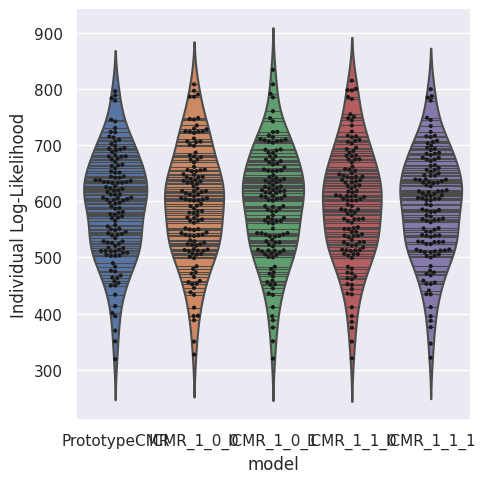

In [5]:
#| code-summary: code -- 3) plot distribution of log-likelihoods across individual subjects

plt.style.use('default')
sns.set(style="darkgrid")

# build individual fits df concatenating results from each model
individual_fits = []
for model_index, model_class in enumerate(models):
    individual_fits.append(
        pd.read_csv(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index])))
individual_fits = pd.concat(individual_fits, ignore_index=True)

# plot distribution of log-likelihoods across individual subjects
g = sns.catplot(x='model', y='likelihood', data=individual_fits, kind='violin', inner='stick')
sns.swarmplot(x="model", y="likelihood", data=individual_fits, color="k", size=3, ax=g.ax)
g.ax.set_ylabel('Individual Log-Likelihood')
#plt.savefig(results_path + 'individual_{}.pdf'.format(section_tag), bbox_inches="tight")

In [6]:
individual_fits

,subject,trial_count,likelihood,model,encoding_drift_rate,start_drift_rate,recall_drift_rate,shared_support,item_support,learning_rate,primacy_scale,primacy_decay,stop_probability_scale,stop_probability_growth,choice_sensitivity,delay_drift_rate,feature_sensitivity,context_sensitivity,learn_first
0,63,28,691.300853,PrototypeCMR,0.749910,9.002816e-02,0.856608,0.011057,2.220446e-16,0.186136,12.943719,1.131110,0.003596,0.374234,0.760005,9.666055e-01,NaN,NaN,NaN
1,64,28,511.162507,PrototypeCMR,0.707526,2.220446e-16,1.000000,0.126618,2.220446e-16,0.571466,1.442432,60.626706,0.002823,0.278856,4.248095,7.452992e-01,NaN,NaN,NaN
2,65,28,508.533873,PrototypeCMR,0.818622,8.980322e-02,0.754794,0.296760,9.747061e-01,0.354851,3.525126,35.192319,0.004930,0.408640,5.280967,3.806502e-01,NaN,NaN,NaN
3,66,28,625.394571,PrototypeCMR,0.805021,9.835137e-02,0.940263,0.755587,2.220446e-16,0.843539,1.065656,61.476278,0.000735,0.469450,9.728036,9.648416e-01,NaN,NaN,NaN
4,67,28,633.189817,PrototypeCMR,0.774673,2.220446e-16,0.892117,0.488035,1.088244e-01,0.932694,1.118315,30.615489,0.000630,0.476598,8.157036,6.807799e-01,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,240,28,513.970288,ICMR_1_1_1,0.938509,2.220446e-16,0.539519,0.023427,1.000000e+00,0.210530,14.493680,4.812341,0.001519,0.637935,1.000000,2.220446e-16,1.0,2.339177,True
626,241,28,639.123671,ICMR_1_1_1,0.836354,3.283872e-04,0.917159,0.022514,5.323021e-01,0.219754,15.080567,78.612453,0.002514,0.457900,1.000000,9.999984e-01,1.0,2.697162,True
627,242,28,512.326223,ICMR_1_1_1,0.706958,4.827358e-02,0.927623,0.021991,6.741501e-01,0.489857,24.015791,1.368423,0.012022,0.368419,1.000000,2.378128e-01,1.0,2.610631,True
628,243,28,616.433475,ICMR_1_1_1,0.938785,1.826270e-02,0.967355,0.000056,1.598222e-02,0.016205,6.166593,47.047688,0.004176,0.324860,1.000000,1.229418e-01,1.0,0.969077,True


In [7]:
#| code-summary: display markdown rendering of summary table
#| echo: false
#| input: false
#| output: asis

summary_table = pd.DataFrame(group.describe().rename(columns={'likelihood':name}).squeeze()
            for name, group in individual_fits[['model', 'likelihood']].groupby('model')).T.to_markdown()

print("""::: {{#fig-{section_tag}fits layout-nrow=2 layout-valign="center"}}

![]({results_path}individual_{section_tag}.pdf)

{summary_table}

{individual_fits_caption}
:::""".format(section_tag=section_tag, summary_table=summary_table, individual_fits_caption=figure_caption, results_path=results_path))

::: {#fig-HealyKahana2014fits layout-nrow=2 layout-valign="center"}

![](results/individual_HealyKahana2014.pdf)

|       |   ICMR_1_0_0 |   ICMR_1_0_1 |   ICMR_1_1_0 |   ICMR_1_1_1 |   PrototypeCMR |
|:------|-------------:|-------------:|-------------:|-------------:|---------------:|
| count |     126      |     126      |      126     |      126     |       126      |
| mean  |     593.034  |     593.045  |      593.425 |      588.869 |       590.049  |
| std   |      99.7471 |      98.6815 |      101.135 |       96.077 |        95.2172 |
| min   |     326.866  |     319.778  |      320.277 |      321.166 |       318.623  |
| 25%   |     523.685  |     526.479  |      524.249 |      524.908 |       521.627  |
| 50%   |     601.51   |     604.719  |      601.669 |      602.175 |       602.197  |
| 75%   |     655.913  |     659.641  |      657.497 |      655.48  |       653.205  |
| max   |     808.808  |     834.9    |      815.567 |      800.246 |       796.672  |

Distribution of

In [8]:
#| code-summary: perform t-tests on individual-level fits
#| output: false
 
from scipy.stats import ttest_rel
import itertools

for combination in itertools.combinations(pd.unique(individual_fits.model), 2):

    print(combination)
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='two-sided'))
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='less'))
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='greater'))
    print()

('PrototypeCMR', 'ICMR_1_0_0')
Ttest_relResult(statistic=-1.7890143270834382, pvalue=0.07603430951266692)
Ttest_relResult(statistic=-1.7890143270834382, pvalue=0.03801715475633346)
Ttest_relResult(statistic=-1.7890143270834382, pvalue=0.9619828452436665)

('PrototypeCMR', 'ICMR_1_0_1')
Ttest_relResult(statistic=-1.8459873151788098, pvalue=0.06725988536660085)
Ttest_relResult(statistic=-1.8459873151788098, pvalue=0.033629942683300426)
Ttest_relResult(statistic=-1.8459873151788098, pvalue=0.9663700573166996)

('PrototypeCMR', 'ICMR_1_1_0')
Ttest_relResult(statistic=-1.8238623288504439, pvalue=0.07056170223993465)
Ttest_relResult(statistic=-1.8238623288504439, pvalue=0.03528085111996732)
Ttest_relResult(statistic=-1.8238623288504439, pvalue=0.9647191488800327)

('PrototypeCMR', 'ICMR_1_1_1')
Ttest_relResult(statistic=2.610508721313847, pvalue=0.010145846651009342)
Ttest_relResult(statistic=2.610508721313847, pvalue=0.9949270766744953)
Ttest_relResult(statistic=2.610508721313847, pvalue=0.

In [9]:
for combination in itertools.combinations(pd.unique(individual_fits.model), 2):

    print(combination)
    print(np.mean(individual_fits[individual_fits.model == combination[0]].likelihood.values < individual_fits[individual_fits.model == combination[1]].likelihood.values), 
        np.mean(individual_fits[individual_fits.model == combination[1]].likelihood.values < individual_fits[individual_fits.model == combination[0]].likelihood.values))

    print(np.sum(individual_fits[individual_fits.model == combination[0]].likelihood.values < individual_fits[individual_fits.model == combination[1]].likelihood.values), 
        np.sum(individual_fits[individual_fits.model == combination[1]].likelihood.values < individual_fits[individual_fits.model == combination[0]].likelihood.values))

    print()

('PrototypeCMR', 'ICMR_1_0_0')
0.4444444444444444 0.5555555555555556
56 70

('PrototypeCMR', 'ICMR_1_0_1')
0.4126984126984127 0.5873015873015873
52 74

('PrototypeCMR', 'ICMR_1_1_0')
0.46825396825396826 0.5317460317460317
59 67

('PrototypeCMR', 'ICMR_1_1_1')
0.42063492063492064 0.5793650793650794
53 73

('ICMR_1_0_0', 'ICMR_1_0_1')
0.46825396825396826 0.5317460317460317
59 67

('ICMR_1_0_0', 'ICMR_1_1_0')
0.5873015873015873 0.4126984126984127
74 52

('ICMR_1_0_0', 'ICMR_1_1_1')
0.5317460317460317 0.46825396825396826
67 59

('ICMR_1_0_1', 'ICMR_1_1_0')
0.5555555555555556 0.4444444444444444
70 56

('ICMR_1_0_1', 'ICMR_1_1_1')
0.5317460317460317 0.46825396825396826
67 59

('ICMR_1_1_0', 'ICMR_1_1_1')
0.5158730158730159 0.48412698412698413
65 61



In [10]:
def model_weights(positive_log_likelihoods, number_parameters, N):
    AIC = 2 * positive_log_likelihoods + 2 * number_parameters
    AICc = AIC #+ (2*np.power(number_parameters, 2) + 2 * number_parameters) / (N - number_parameters - 2)
    AICd = AIC - np.min(AICc)
    #return AICd
    AICw = np.exp(-.5 * AICd) / np.sum(np.exp(-.5 * AICd))
    return AICw

aicw = {'Model': [], 'Subject': [], 'AICw': []}

total_nlns = np.zeros(len(models))
for subject_index, subject in enumerate(pd.unique(events.subject)):

    subject_specific_trial_mask = np.logical_and(
                    generate_trial_mask(events, f'subject == {subject}'), trial_mask)

    nlnLs = []
    for model_index, model_class in enumerate(models):
        nlnLs.append(
            individual_fits[individual_fits.model == model_names[model_index]].likelihood.values[subject_index])
    nlnLs = np.array(nlnLs)
    total_nlns += nlnLs
    
    weights = model_weights(nlnLs, len(free_parameters[model_index]), np.sum(subject_specific_trial_mask))
    #print(weights)
    for model_index, model_class in enumerate(models):
        aicw['Model'].append(model_names[model_index])
        aicw['Subject'].append(subject)
        aicw['AICw'].append(weights[model_index])

aicw = pd.DataFrame(data=aicw)
total_aicw = model_weights(total_nlns, len(free_parameters[model_index]), np.sum(trial_mask))
print(total_aicw)

[2.45998942e-065 1.16157258e-228 3.08462712e-229 4.76455723e-250
 1.00000000e+000]


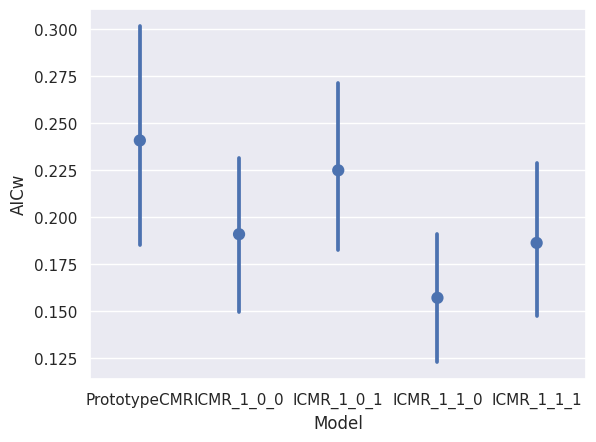

In [11]:
import seaborn as sns
sns.set_theme(style="darkgrid")
x = sns.pointplot(x="Model", y="AICw", data=aicw, join=False)

plt.show()

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [12]:
sns.set(style='darkgrid')

# for each unique list length
if not (isinstance(list_lengths, list) or isinstance(list_lengths, List)): 
    list_lengths = [list_lengths]

for list_length in list_lengths:

    #fig, axes = plt.subplots(nrows=len(models), ncols=3, figsize=(15, int(4*len(models))), sharey=False)
    
    # for each unique model
    for model_index, model_class in enumerate(models):

        # load sim_df from csv if it exists
        sim_df_path = results_path + '{}_{}_ll{}_sim_df.csv'.format(section_tag, model_names[model_index], list_length)
        if os.path.isfile(sim_df_path):
            sim_df = pd.read_csv(sim_df_path)
            print('sim_df for {} with tag {} and list length {} already exists'.format(model_names[model_index], section_tag, list_length))

        # otherwise, generate it
        else:

            # for each unique matching entry in individual df
            sim_dfs = []
            for subject in pd.unique(individual_fits.subject):
                
                fit_result = individual_fits.query(f'subject == {subject} & model == "{model_names[model_index]}"')

                # configure model based on specified parameters
                fitted_parameters = Dict.empty(
                    key_type=types.unicode_type, value_type=types.float64
                )
                for i in range(len(free_parameters[model_index])):
                    fitted_parameters[free_parameters[model_index][i]] = fit_result[free_parameters[model_index][i]].values[0]
                for key in fixed_parameters[model_index]:
                    fitted_parameters[key] = fixed_parameters[model_index][key]

                # simulate df based on specified trial_count and experiment_count
                #model = model_class(list_length, list_length, fitted_parameters)
                sim_dfs.append(simulate_df_from_events(model, fit_result['trial_count'].values[0] * experiment_count))
                sim_dfs[-1].list = sim_dfs[-1].subject
                sim_dfs[-1].subject = subject

            # concatenate simulations into one dataframe
            sim_df = pd.concat(sim_dfs)

            # save sim_df to csv
            sim_df.to_csv(results_path +'{}_{}_ll{}_sim_df.csv'.format(section_tag, model_names[model_index], list_length), index=False)

        # design general filter for analysis df
        if len(list_lengths) > 1:
            analysis_query = trial_query + f' & list_length == {list_length}'
        else:
            analysis_query = trial_query

        # generate plot for each parametrized analysis and model
        for analysis_index, analysis_function in enumerate(analyses):
            analysis_name = analysis_names[analysis_index]
            axis = analysis_function(
                [events, sim_df], analysis_query, contrast_name="source", labels=["data", model_names[model_index]])
            plt.savefig(results_path+'{}_{}_ll{}_{}.pdf'.format(section_tag, model_names[model_index], list_length, analysis_name), bbox_inches="tight")

NameError: name 'simulate_df_from_events' is not defined